In [1]:
import pandas as pd
import numpy as np
import math
import json
from dateutil import rrule
from datetime import datetime
from time import time
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score
import visuals as vs
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Define所有函数：

In [72]:
# offer id和offer_id这两列重复了，需要把他们合并：如果offer_id为空，则把offer id的值填到offer_id里
def combine_offer_id(a, b):
    if pd.isna(b):
        return a
    else:
        return b
    
    
# 创建判断行为是否发生在有效期的函数
def action_in_valiperd(receive_time, duration, action_time):
    if action_time >= receive_time and action_time <= receive_time+duration*24:
        return 1
    else:
        return 0
    
    
# 创建判断顾客的行为是否收到offer的影响
def offer_has_effect(is_viewed, is_used, has_trans, offer_type):
    if is_viewed == 0: 
        return 0   # 只要用户没看过offer，都算没影响
    else:
        if has_trans == 0:
            return 0   # 如果被看过，但是没有交易，也算没影响 （没有交易，但是用券的情况应该不存在）
        else: 
            if is_used == 1:
                return 1 # 被看过，有交易，且用券，说明有影响
            else: 
                if offer_type == 'informational':
                    return 1 # 被看过，有交易，没用券，但是是消息类的推送（不可能用券），说明有影响
                else:
                    return 0 # 非消息类，即使有交易，没用券也认为没影响

# 根据trans_effect['in_valiperd']和trans_effect['is_effect']两个字段，来判断该交易是否收到offer影响。
def is_trans_effect(in_valiperd, is_effect):
    if pd.isna(is_effect) == False and pd.isna(in_valiperd) == False:
        return in_valiperd*is_effect
    else:
        return 0

    
# 给顾客的income分类
def income_type(x):
    if pd.isna(x):
        return x
    elif x <= 50000:
        return "0~50000"
    elif x > 50000 and x <= 100000:
        return "50001~100000"
    elif x > 100000 and x <= 150000:
        return "100000~150000"
    elif x > 150000 and x <= 200000:
        return "150000~200000"
    else:
        return ">200000"
    
    
# 给顾客的年龄age分类
def age_type(x):
    if pd.isna(x) or x == 118:
        return "None"
    elif x < 10:
        return "0~9y"
    elif x >= 10 and x < 20:
        return "10~19y"
    elif x >= 20 and x < 30:
        return "20~29y"
    elif x >= 30 and x < 40:
        return "30~39y"
    elif x >= 40 and x < 50:
        return "40~49y"
    elif x >= 50 and x < 60:
        return "50~59y"
    elif x >= 60 and x < 70:
        return "60~69y"
    elif x >= 70 and x < 80:
        return "70~79y"
    elif x >= 80 and x < 90:
        return "80~89y"
    elif x >= 90 and x < 100:
        return "90~99y"
    else:
        return ">100y"
    
# 根据x的条件，用y赋值
def filter_x(x, y):
    if x == 1:
        return y
    else:
        return 0
    
    
# 计算日期x（int：20170421）距离当前日期有多少天
def days_from_x(x):
    if pd.isna(x):
        return x
    else:
        now = datetime.now()
        try: 
            start_date = parse(str(x))
            #datediff = rrule.rrule(freq = rrule.DAILY,dtstart=start_date,until=now)   
            #return datediff.count()   #这个计算起来速度太慢，可能是因为有count的原因
            datediff = now - start_date
            return datediff.days
        except:
            return np.nan

        
# 把天数按照半年一档来划分（days_type）
def days_type(x):
    if pd.isna(x):
        return x
    else:
        return int(x/180)

        
# 转化int日期x（int：20170421）到datetime （废弃）
def x_to_datetime(x):
    if pd.isna(x):
        return x
    else:
        try: 
            start_date = parse(str(x))
            return start_date
        except:
            return np.nan

### 数据清洗：处理transcript里的value字段，拆分成多个列

In [3]:
# 把value的值拆成多个列（根据字典里的类型）
transcript_value_s = transcript['value'].apply(pd.Series)

# offer id和offer_id这两列重复了，需要把他们合并：如果offer_id为空，则把offer id的值填到offer_id里
transcript_value_s['offer_id']=transcript_value_s.apply(lambda transcript_value_s: combine_offer_id(transcript_value_s['offer id'],transcript_value_s['offer_id']),axis=1)

# 去掉多余的offer id列
transcript_value = transcript_value_s.drop(['offer id'], axis=1)

transcript_value.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [4]:
# 把加工好的transcript_value合并到transcript表后面
transcript_new = pd.concat([transcript, transcript_value], axis=1, join_axes=[transcript.index])

# 查看event类型有几种：
# offer received
# offer viewed
# transaction
# offer completed
transcript_new.drop_duplicates(['event'])

,event,person,time,value,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83,NaN,NaN
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,NaN,2906b810c7d4411798c6938adc9daaa5,2.0


In [49]:
# 重命名id列，使后面的merge更方便
portfolio.rename(columns={'id':'offer_id'},inplace=True) 
# 重命名id列，使后面的merge更方便
profile.rename(columns={'id':'person_id'},inplace=True) 

# 给顾客的income分类
profile['income_type']=profile.apply(lambda profile: income_type(profile['income']),axis=1)
# 给顾客的年龄age分类
profile['age_type']=profile.apply(lambda profile: age_type(profile['age']),axis=1)
# 按照入会日期，计算每个顾客入会的时长
profile['membr_days'] = profile.apply(lambda profile: days_from_x(profile['became_member_on']),axis=1)
# 以一个季度（90天）为单位，划分顾客的入会时间
profile['membr_days_type'] = profile['membr_days'].apply(lambda x: days_type(x)) 

profile.head()

,age,became_member_on,gender,person_id,income,income_type,age_type,membr_days,membr_days_type
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,None,1128,6
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,100000~150000,50~59y,975,5
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,None,613,3
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,50001~100000,70~79y,1042,5
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,None,955,5


# A：数据分析阶段
## 1. 计算每个顾客对于每种offer的得分（反应）


In [10]:
# 1.1.1 把收到offer到行为单独提取出来
offer_received = transcript_new[transcript_new['event'] == 'offer received'].loc[:,['person','offer_id','time']]
offer_received.rename(columns={'time':'receive_time','person':'person_id'},inplace=True) 

# 1.1.2 关联portfolio表，取得券的有效期
offer_received = pd.merge(offer_received, portfolio, how='left', on=['offer_id'])


# 1.2.1 把offer view的行为单独提取出来
offer_viewed = transcript_new[transcript_new['event'] == 'offer viewed'].loc[:,['person','offer_id','time']]
offer_viewed.rename(columns={'time':'view_time','person':'person_id'},inplace=True) 

# 1.2.2 收到offer到行为左连接view的行为，来计算多少收到offer后被查看了。（如果只有view行为，没有收到行为，理论上不应该，这里当作脏数据删除了）
offer_received = pd.merge(offer_received, offer_viewed, how='left', on=['person_id','offer_id'])

# 1.2.3 添加一列，判断在有效期内是否有view发生（注意：一条offer的推送可能关联多个view的行为，这里判断每条view行为是否在有效期内）
offer_received['is_viewed']=offer_received.apply(lambda offer_received: 
                                                 action_in_valiperd(offer_received['receive_time'], 
                                                                    offer_received['duration'], 
                                                                    offer_received['view_time']),axis=1)

# 1.2.4 得到每次用户收到offer后，是否在有效期内阅读了。（注意：一条offer用户可能阅读多次，这里统一只计为1-是否阅读；如果后续需要区分阅读次数，可以再改）
offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration'],as_index=False)['is_viewed'].max()



# 1.3.1 把offer use的行为单独提取出来（跟view的行为处理方法一致）
offer_completed = transcript_new[transcript_new['event'] == 'offer completed'].loc[:,['person','offer_id','time','reward']]
offer_completed.rename(columns={'time':'use_time','person':'person_id'},inplace=True) 

# 1.3.2 收到offer到行为左连接view的行为，来计算多少收到offer后被查看了。（如果只有view行为，没有收到行为，理论上不应该，这里当作脏数据删除了）
offer_received = pd.merge(offer_received, offer_completed, how='left', on=['person_id','offer_id'])

# 1.3.3 添加一列，判断在有效期内是否有use发生（注意：一条offer的推送也可能关联多个use的行为，不一定在同一有效期）
offer_received['is_used']=offer_received.apply(lambda offer_received: 
                                                 action_in_valiperd(offer_received['receive_time'], 
                                                                    offer_received['duration'], 
                                                                    offer_received['use_time']),axis=1)


# 1.3.4 得到每次用户收到offer后，是否在有效期内使用了。（注意：原则上一次推送的offer，只能在有效期内被使用一次，
#      但是也有可能两次推送同样的offer，且有效期重叠，这样就会得到每条推送都关联了2条使用记录，且reward金额可能不同。
#      但是，根据现有数据，没有办法区分哪条use是对应哪条推送的，所以统一都取一条最大的）
offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration','is_viewed'],as_index=False)['is_used'].max()

#offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration','is_viewed'],as_index=False)['is_used','reward'].max()
# 注意：使用max有一个问题，就是选取的是每一列的最大值，而不是选取最大值的那一行，也就是说只能在选取单列的最大值的时候才是准确的.
#      所以如果有2条以上使用记录，那么这个reward的金额可能不是真正用那一张的金额


# 1.4.1 把transaction的“交易”行为单独提取出来（这是每个顾客所有的交易记录）
transaction_log = transcript_new[transcript_new['event'] == 'transaction'].loc[:,['person','time','amount']]
transaction_log.rename(columns={'time':'transaction_time','person':'person_id'},inplace=True) 

# 1.4.2 收到offer到行为左连接交易行为，来计算offer的有效期内，是否有交易产生。（这里只看和收到offer的人有关的交易数据）
offer_received = pd.merge(offer_received, transaction_log, how='left', on=['person_id'])

# 1.4.3 添加一列，判断在有效期内是否有use发生（注意：一条offer的推送也可能关联多个use的行为，不一定在同一有效期）
offer_received['has_trans']=offer_received.apply(lambda offer_received: 
                                                 action_in_valiperd(offer_received['receive_time'], 
                                                                    offer_received['duration'], 
                                                                    offer_received['transaction_time']),axis=1)

# 1.4.4 得到每次用户收到offer后，是否在有效期内有交易。（注意：原则上如果有交易，不一定用券；但是用券了，一定有交易）
offer_received = offer_received.groupby(['person_id','offer_id','receive_time','duration','is_viewed','is_used'],as_index=False)['has_trans'].max()
offer_received.head()

,person_id,offer_id,receive_time,duration,is_viewed,is_used,has_trans
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,7,0,1,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,4,1,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,3,1,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,5,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,10,1,1,1


In [12]:
# Data-Check：查询是否存在用券了，但是没有交易的情况（理论上不应该）
offer_received.query('is_used == 1 and has_trans == 0')
# 还好没有这种情况，说明数据还是比较完整的。

,person_id,offer_id,receive_time,duration,is_viewed,is_used,has_trans


In [11]:
# 1.5.1 再次关联portfolio表，取得券的类型（后续判断会用到）
offer_received = pd.merge(offer_received, portfolio, how='left', on=['offer_id'])
offer_received = offer_received.drop(['duration_y'], axis=1)
offer_received.rename(columns={'duration_x':'duration'},inplace=True) 

# 1.5.2 添加一列，判断offer对于顾客的影响
offer_received['is_effect']=offer_received.apply(lambda offer_received: 
                                                 offer_has_effect(offer_received['is_viewed'], 
                                                                    offer_received['is_used'], 
                                                                    offer_received['has_trans'],
                                                                    offer_received['offer_type']),axis=1)

# 1.5.3 增加一列is_receive，全部赋值为1，因为所有记录都是收到offer的。这个方便后续的groupby计算
offer_received['is_receive'] = 1
offer_received.head()

,person_id,offer_id,receive_time,duration,is_viewed,is_used,has_trans,channels,difficulty,offer_type,reward,is_effect,is_receive
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,7,0,1,1,"[web, email, mobile]",10,discount,2,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,4,1,0,1,"[web, email, mobile]",0,informational,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,3,1,0,1,"[email, mobile, social]",0,informational,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,5,1,1,1,"[web, email, mobile, social]",5,bogo,5,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,10,1,1,1,"[web, email, mobile, social]",10,discount,2,1,1


In [4]:
#######------------到这里，第一张宽表就做好了。---------------------

### 分析：计算出每个顾客对于每种offer的反应
如果一个顾客，对于offer1，收到3次，有2次有反应，那么该顾客对于次offer的反应score = 2/3

In [12]:
# 1.6.1 计算出每个顾客对于每种offer的反应
user_offer_reaction = offer_received.groupby(['person_id','offer_id'],as_index=False)['is_effect','is_receive'].sum()
user_offer_reaction.head()

,person_id,offer_id,is_effect,is_receive
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1


In [13]:
user_offer_reaction['effect_score'] = user_offer_reaction['is_effect']/user_offer_reaction['is_receive']
user_offer_reaction.head()

,person_id,offer_id,is_effect,is_receive,effect_score
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1.0


## 2. 计算每个顾客的消费分布，是否是offer驱动

In [49]:
# ------在1.4.1中，已经把transaction的“交易”行为单独提取出来了（这是每个顾客所有的交易记录）
transaction_log.shape

(138953, 3)

In [14]:
# 2.1.1 注意：这里没有交易id，需要把index作为交易的唯一id，因为可能存在同一个人，同一时间，同等金额的交易。
transaction_log['trans_id'] = transaction_log.index

# 2.2.1 所有交易行为左连接第一张宽表（每个顾客对于每个收到的offer的反应，同一个offer可能收到多次）
trans_effect = pd.merge(transaction_log, offer_received, how='left', on=['person_id'])

# 2.2.2 添加一列，判断该交易是否在offer的有效期内（注意：一条交易可能关联多条offer推送的行为，且可能有多条都在有效期内）
trans_effect['in_valiperd']=trans_effect.apply(lambda trans_effect: 
                                                 action_in_valiperd(trans_effect['receive_time'], 
                                                                    trans_effect['duration'], 
                                                                    trans_effect['transaction_time']),axis=1)

# 2.2.3 用in_valiperd和is_effect结合看该笔交易是否收到offer的影响： 只有is_effect和in_valiperd同时为1的情况下，才算。
trans_effect['trans_effect'] = trans_effect.apply(lambda trans_effect: 
                                                 is_trans_effect(trans_effect['in_valiperd'], 
                                                                    trans_effect['is_effect']),axis=1)

# 2.2.4 得到每笔交易是受到offer影响
trans_effect = trans_effect.groupby(['trans_id','person_id','transaction_time','amount'],as_index=False)['in_valiperd','trans_effect'].max()

trans_effect.head()


,trans_id,person_id,transaction_time,amount,in_valiperd,trans_effect
0,12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,1,0.0
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,1.0
2,12659,54890f68699049c2a04d415abc25e717,0,13.23,0,0.0
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,1,1.0
4,12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,1.0


In [3]:
###--------到这里，第二张宽表完成了。

### 分析：结合顾客的属性，分析哪些顾客容易受offer影响

In [15]:
# 2.3.1 结合顾客的属性，分析哪些顾客容易受offer影响
user_trans_effect = pd.merge(trans_effect, profile, how='left', on=['person_id'])
user_trans_effect.head()

,trans_id,person_id,transaction_time,amount,in_valiperd,trans_effect,age,became_member_on,gender,income,income_type,age_type,membr_days,membr_days_type
0,12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,1,0.0,20,20160711,F,30000.0,0~50000,20~29y,1344,14
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,1.0,42,20160117,M,96000.0,50001~100000,40~49y,1520,16
2,12659,54890f68699049c2a04d415abc25e717,0,13.23,0,0.0,36,20171228,M,56000.0,50001~100000,30~39y,809,8
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,1,1.0,55,20171016,F,94000.0,50001~100000,50~59y,882,9
4,12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,1.0,39,20171217,F,67000.0,50001~100000,30~39y,820,9


In [54]:
user_trans_effect.to_excel('user_trans_effect.xlsx')

In [16]:
# 2.3.2 计算每个顾客的客单价，受影响的订单数，不受影响的订单数，受影响的订单金额，不受影响的订单金额
user_summary = trans_effect
user_summary['trans_cnt'] = 1
user_summary['effect_amount'] = user_summary.apply(lambda user_summary: 
                                                 filter_x(user_summary['trans_effect'], 
                                                          user_summary['amount']),axis=1)

user_summary.head()

,trans_id,person_id,transaction_time,amount,in_valiperd,trans_effect,trans_cnt,effect_amount
0,12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,1,0.0,1,0.00
1,12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,1,1.0,1,34.56
2,12659,54890f68699049c2a04d415abc25e717,0,13.23,0,0.0,1,0.00
3,12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,1,1.0,1,19.51
4,12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,1,1.0,1,18.97


In [17]:
user_summary = user_summary.groupby(['person_id'],as_index=False)['trans_cnt','amount','in_valiperd','trans_effect','effect_amount'].sum()
user_summary.head()

,person_id,trans_cnt,amount,in_valiperd,trans_effect,effect_amount
0,0009655768c64bdeb2e877511632db8f,8,127.60,8,8.0,127.60
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,0,0.0,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,4,4.0,65.97
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,6,5.0,115.57
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,11,11.0,137.78


In [18]:
# 结合顾客的属性，分析哪些顾客容易受offer影响
user_summary = pd.merge(user_summary, profile, how='left', on=['person_id'])
user_summary.head()

,person_id,trans_cnt,amount,in_valiperd,trans_effect,effect_amount,age,became_member_on,gender,income,income_type,age_type,membr_days,membr_days_type
0,0009655768c64bdeb2e877511632db8f,8,127.60,8,8.0,127.60,33,20170421,M,72000.0,50001~100000,30~39y,1060,11
1,00116118485d4dfda04fdbaba9a87b5c,3,4.09,0,0.0,0.00,118,20180425,None,NaN,NaN,None,691,7
2,0011e0d4e6b944f998e987f904e8c1e5,5,79.46,4,4.0,65.97,40,20180109,O,57000.0,50001~100000,40~49y,797,8
3,0020c2b971eb4e9188eac86d93036a77,8,196.86,6,5.0,115.57,59,20160304,F,90000.0,50001~100000,50~59y,1473,16
4,0020ccbbb6d84e358d3414a3ff76cffd,12,154.05,11,11.0,137.78,24,20161111,F,60000.0,50001~100000,20~29y,1221,13


In [19]:
user_summary.to_excel('user_summary.xlsx')

```python

```

# B：模型阶段：
## 1. 预测模型Model 1：用机器学习模型预测顾客是否会受到某offer的影响
### 1.1 准备数据：根据第一张宽表的内容，加入顾客的属性，以及券的属性，得到每种顾客对于每种券，是否会受到影响

In [10]:
# 1.1.1 查看数据集中，is_effect的记录数，占比。1和0的条数是否偏差太大

n_records = len(offer_received)

n_effect = len(offer_received[offer_received['is_effect'] == 1])

n_not_effect = len(offer_received[offer_received['is_effect'] == 0])

effect_percent = n_effect/n_records*100

# Print the results
print("Total number of records: {}".format(n_records))
print("effected records: {}".format(n_effect))
print("not effected records: {}".format(n_not_effect))
print("Percentage of effected records: {}%".format(effect_percent))

Total number of records: 76277
effected records: 34625
not effected records: 41652
Percentage of effected records: 45.39376220879164%


###### 还好，占比还算均匀，没有1特别多，或者0特别多的情况。

In [20]:
# 1.1.2 准备数据 - 加入顾客的属性，以及券的属性

user_offer_effect = offer_received.loc[:,['person_id','offer_id','duration','difficulty','reward','offer_type','is_effect']] 

# 加入顾客的属性
user_offer_effect = pd.merge(user_offer_effect, profile, how='left', on=['person_id'])

# 选取后续模型用到的列
user_offer_effect = user_offer_effect.loc[:,['age','gender','income','membr_days','duration','difficulty','reward','offer_type','is_effect']] 


# 1.1.3 Split the data into features and target label
effect_raw = user_offer_effect['is_effect']
features_raw = user_offer_effect.drop('is_effect', axis = 1)
print(effect_raw.shape)
print(features_raw.shape)


# 1.1.5 One-hot encode 'gender' and 'offer_type' using pandas.get_dummies()
features_onehot = pd.get_dummies(features_raw)
#features_onehot.head()

# effect_raw 本来就是0，1的列，不用处理

# 1.1.6 查看数据集里是否有缺失值
#features_onehot.isnull().sum(axis=0)
#effect_raw.isnull().sum(axis=0)


# 1.1.7 处理缺失值
# 把income的值单独提出来
income = features_onehot['income']
income = income.dropna()

# 计算income的平均值
print(np.mean(income))
#计算income的中位数
print(np.median(income))
# 计算income的众数
gm = pd.Series(data=income)
income_mode = gm.mode()[0]
print(income_mode)

# 用众数替换掉income里掉NaN
values = {'income': income_mode}
features_no_na = features_onehot.fillna(value=values)

# 检查处理后还有没有空值
#features_no_na.isnull().sum(axis=0)


# 1.1.4 Normalizing Numerical Features
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'membr_days', 'income', 'duration', 'difficulty','reward']

# 进行标准化计算 （值控制在0～1之间）
features_final = pd.DataFrame(data = features_no_na)
features_final[numerical] = scaler.fit_transform(features_no_na[numerical])

# Show an example of a record with scaling applied
#display(features_final.head())


# 1.1.8 准备训练集和测试集 Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    effect_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

(76277,)
(76277, 8)
65371.61847190268
64000.0
73000.0
Training set has 61021 samples.
Testing set has 15256 samples.


user_offer_effect['membr_days']在600～2400之前，数据比较老了，所以没有什么新会员。在后面预测的时候也尽量控制在这个区间就好

### 1.2 训练模型

In [21]:
# 1.2.1 Naive Predictor Performance 如果预测结果是永真（都是1），那么accuracy and F-score 是多少？
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
TP = np.sum(effect_raw)
FP = effect_raw.count() - TP
TN = 0
FN = 0
accuracy = (TP+TN)/effect_raw.count()
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta*beta)*(precision*recall)/(beta*beta*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.4539, F-score: 0.5096]


#### 1.2.2  Creating a Training and Predicting Pipeline

In [22]:
# 1.2.2 创建预测模型 Pipeline （可以根据不同的model，来测试结果）
def train_predict(learner, sample_size, first_n_train, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - first_n_train: first n training samples, for accuracy & F1-score on training subset 
       - X_train: features training set
       - y_train: y training set
       - X_test: features testing set
       - y_test: y testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first n training samples(X_train[:]) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:first_n_train])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first n training samples which is y_train[:first_n_train]
    results['acc_train'] = accuracy_score(y_train[:first_n_train], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first n training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:first_n_train], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

#### 1.2.3 Initial Model Evaluation

GaussianNB trained on 610 samples.
GaussianNB trained on 6102 samples.
GaussianNB trained on 61021 samples.
LogisticRegression trained on 610 samples.
LogisticRegression trained on 6102 samples.
LogisticRegression trained on 61021 samples.
LinearSVC trained on 610 samples.
LinearSVC trained on 6102 samples.
LinearSVC trained on 61021 samples.


/Users/vickieliu/Documents/Git/DataScientist_Udacity/DSND_Starbucks_Project/visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


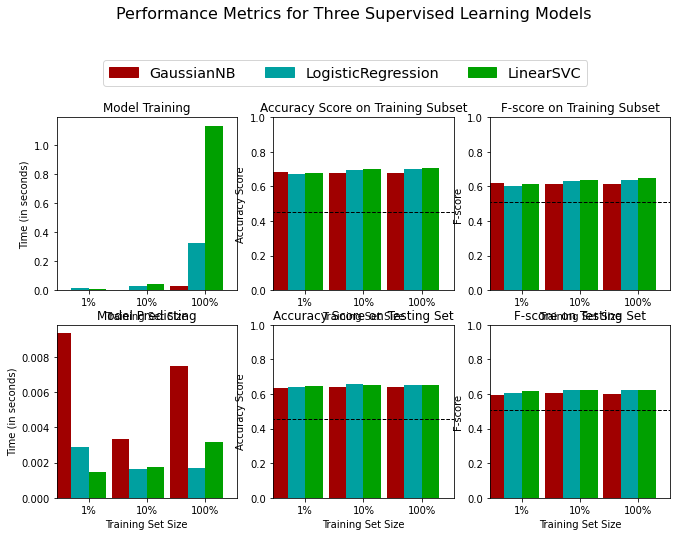

In [23]:
# 1.2.3 用不同的model训练数据集，得到结果的分析图表
# 这里选择3种模型：
# GaussianNB
# svm
# LogisticRegression

# Initialize the three models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=1)
clf_C = svm.LinearSVC(random_state=1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# set first n training samples
first_n_train = 300

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, first_n_train, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

#### Choosing the Best Model - Logistic Regression looks better overall.


#### 1.2.4 Model Tuning
GridSearchCV 在最新版sklearn里有变更，看最新使用文档
- Import [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).

In [21]:
# 1.2.4 Model Tuning

# Initialize the classifier
clf = LogisticRegression(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'class_weight': [None,'balanced',{0:0.2,1:0.8},{0:0.45,1:0.55},{0:0.48,1:0.52},{0:0.5,1:0.5},{0:0.52,1:0.48},{0:0.55,1:0.45},{0:0.58,1:0.42},{0:0.6,1:0.4}], 
              'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
             'max_iter':[200, 500]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the Unoptimized and Optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print(clf.get_params())
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf.get_params())

Unoptimized model
------
Accuracy score on testing data: 0.6523
F-score on testing data: 0.6211
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Optimized Model
------
Final accuracy score on the testing data: 0.6559
Final F-score on the testing data: 0.6252
{'C': 1.0, 'class_weight': {0: 0.45, 1: 0.55}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 200, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


这里最好的结果也只有0.6多，并不是特别理想。这可能和我们的feature有限有关，也可能和数据集有关。我们并不能很准确地预测用户的行为，但是，这个模型结果可以作为一个参考，总比没有任何预测好。总之，将来如果有其他feature出现，可以加入考虑。

#### 1.2.5 Extracting Feature Importance
看看哪些feature是重要的

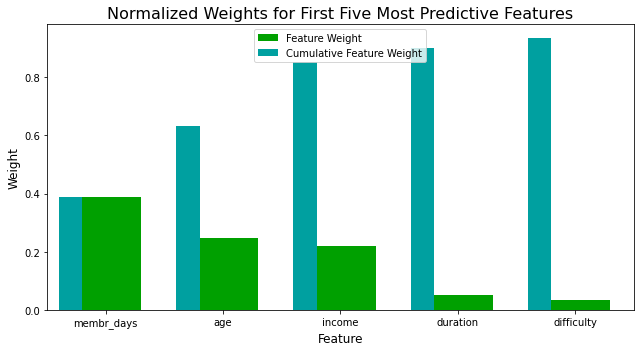

In [24]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state = 1).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [ ]:
# reward居然不在前5个里面。。。。。看来优惠的力度其实不是最重要的。（至少在发的这几种券里面）

#### 1.2.6 Feature Selection （Optional）
上面5个feature可以代表80%+的重要度，所以可以只用这5个feature来建模试试看，准确率是否有所下降

In [28]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.6559
F-score on testing data: 0.6252

Final Model trained on reduced data
------
Accuracy on testing data: 0.6277
F-score on testing data: 0.5965


对于F-Score，减少feature后下降到0.6以下。这里我们用的feature本来就不多，所以我还是建议保留全部feature。如果原来的feature特别多，减少feature的数量可以大大提高运算速度。

## 2. 使用Model1
### 2.1 处理新的预测数据

In [45]:
# 2.1.1 创建n个需要预测的新用户，看给他们推送什么样的券。
# 注意：这里创建的新用户，假设每个属性都不为空。方便后续预测。在实际项目中，如果为空，要先处理下。
n_person = 1
new_person = pd.DataFrame({'age': np.random.randint(20, 70, n_person), 
                    'gender': np.random.choice(['M', 'F'], n_person), 
                    'income': np.random.randint(20000, 120000, n_person),
                    'membr_days': np.random.randint(600, 2400, n_person),
                    'key': 'key'})
new_person['p_id'] = range(len(new_person))
new_person

,age,gender,income,membr_days,key,p_id
0,56,F,54922,616,key,0


In [115]:
# 2.1.2 把需要预测的新用户属性，和每一张券做成一个feature df，预测该用户对于每一种券，是否可能有反应
# 在portfolio中加入一个key，为了后续做笛卡尔积运算
portfolio_1 = portfolio
portfolio_1['key'] = 'key'

# 把每个顾客的属性 和 所有的券都关联起来， 做成要预测的feature数据集
new_person_feature = pd.merge(new_person, portfolio_1, on = 'key')
  

# 选取模型用到的列
new_person_feature = new_person_feature.loc[:,['p_id','age','gender','income','membr_days','duration','difficulty','reward','offer_type']] 
new_person_feature

,p_id,age,gender,income,membr_days,duration,difficulty,reward,offer_type
0,0,62,M,115866,1895,7,10,10,bogo
1,0,62,M,115866,1895,5,10,10,bogo
2,0,62,M,115866,1895,4,0,0,informational
3,0,62,M,115866,1895,7,5,5,bogo
4,0,62,M,115866,1895,10,20,5,discount
5,0,62,M,115866,1895,7,7,3,discount
6,0,62,M,115866,1895,10,10,2,discount
7,0,62,M,115866,1895,3,0,0,informational
8,0,62,M,115866,1895,5,5,5,bogo
9,0,62,M,115866,1895,7,10,2,discount


为了数据归一化（使特征数据方差为1，均值为0），我们需要计算特征数据的均值μ和方差σ^2，再使用下面的公式进行归一化：
<img src="归一化公式.gif"/>
我们在模型训练的时候已经调用过fit_transform()，其实找到了均值μ和方差σ^2，即我们已经找到了转换规则，我们把这个规则利用在训练集上，同样，我们可以直接将其运用到测试集上（新的数据集上），所以在测试集（数据集）上的处理，我们只需要标准化数据而不需要再次拟合数据。用一幅图展示如下：
<img src="scaler_fit_transform.png"/>
reference from：https://blog.csdn.net/quiet_girl/article/details/72517053

In [116]:
# 2.1.3 Normalizing Numerical Features

# 进行标准化计算 （值控制在0～1之间）之前已经fit了，所以这里只需要标准化数据而不需要再次拟合数据
new_person_feature[numerical] = scaler.transform(new_person_feature[numerical])

# Show an example of a record with scaling applied
display(new_person_feature)

,p_id,age,gender,income,membr_days,duration,difficulty,reward,offer_type
0,0,0.44,M,0.954067,0.712562,0.571429,0.50,1.0,bogo
1,0,0.44,M,0.954067,0.712562,0.285714,0.50,1.0,bogo
2,0,0.44,M,0.954067,0.712562,0.142857,0.00,0.0,informational
3,0,0.44,M,0.954067,0.712562,0.571429,0.25,0.5,bogo
4,0,0.44,M,0.954067,0.712562,1.000000,1.00,0.5,discount
5,0,0.44,M,0.954067,0.712562,0.571429,0.35,0.3,discount
6,0,0.44,M,0.954067,0.712562,1.000000,0.50,0.2,discount
7,0,0.44,M,0.954067,0.712562,0.000000,0.00,0.0,informational
8,0,0.44,M,0.954067,0.712562,0.285714,0.25,0.5,bogo
9,0,0.44,M,0.954067,0.712562,0.571429,0.50,0.2,discount


In [128]:
# 2.1.4 One-hot encode 'gender' and 'offer_type' using pandas.get_dummies()

new_person_feature = pd.get_dummies(new_person_feature)

_, new_feature = features_onehot.align(new_person_feature, join='left', axis=1, fill_value=0)

new_feature

,age,income,membr_days,duration,difficulty,reward,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,0.44,0.954067,0.712562,0.571429,0.50,1.0,0,1,0,1,0,0
1,0.44,0.954067,0.712562,0.285714,0.50,1.0,0,1,0,1,0,0
2,0.44,0.954067,0.712562,0.142857,0.00,0.0,0,1,0,0,0,1
3,0.44,0.954067,0.712562,0.571429,0.25,0.5,0,1,0,1,0,0
4,0.44,0.954067,0.712562,1.000000,1.00,0.5,0,1,0,0,1,0
5,0.44,0.954067,0.712562,0.571429,0.35,0.3,0,1,0,0,1,0
6,0.44,0.954067,0.712562,1.000000,0.50,0.2,0,1,0,0,1,0
7,0.44,0.954067,0.712562,0.000000,0.00,0.0,0,1,0,0,0,1
8,0.44,0.954067,0.712562,0.285714,0.25,0.5,0,1,0,1,0,0
9,0.44,0.954067,0.712562,0.571429,0.50,0.2,0,1,0,0,1,0


### 2.2 预测新数据

In [129]:
new_predict = best_clf.predict(new_feature)
new_predict

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

该用户对每个券可能都有反应。。。 不过，从之前feature的权重知道，最大的影响因素是membr_days，其次是年龄。也就是说，使用该模型，大概率预测的是用户对于优惠是否有反应，而用户对于券之间的偏好并不明显。

In [25]:
# 把p_id加回去。。。要在结果上加，如果在feature上加的话，模型的入参就不对了。
#new_feature = pd.concat([new_person_feature['p_id'], new_predict], axis=1, join_axes=[new_person_feature.index])
#new_feature

## 3. Model2: 根据用户的属性阶段，计算每种类型的用户，对于每种券的反应（effect_score）
### 3.1 创建一张表，用来查询每种类型的用户，对于券的反应

In [43]:
# 3.1.1 根据第一张宽表分析统计后，得到对每个用户对于每个offer（不一定是全部offer，因为可能没收到过）对反应
# user_offer_reaction.head()


# 3.1.2 加入顾客的属性
userprofile_offer = pd.merge(user_offer_reaction, profile, how='left', on=['person_id'])
#userprofile_offer.head()


# 3.1.3 计算每种类型的用户，对于每种券的反应
userpro_offer_summary = userprofile_offer.groupby(['age_type','gender','income_type','membr_days_type','offer_id'],as_index=False)['is_effect','is_receive'].sum()
userpro_offer_summary['effect_rate'] = userpro_offer_summary['is_effect']/userpro_offer_summary['is_receive']
userpro_offer_summary['effect_score'] = userpro_offer_summary['effect_rate']*userpro_offer_summary['is_receive']
userpro_offer_summary.head()

,age_type,gender,income_type,membr_days_type,offer_id,is_effect,is_receive,effect_rate,effect_score
0,10~19y,F,0~50000,3,3f207df678b143eea3cee63160fa8bed,0,3,0.0,0.0
1,10~19y,F,0~50000,3,4d5c57ea9a6940dd891ad53e9dbe8da0,0,3,0.0,0.0
2,10~19y,F,0~50000,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1.0,1.0
3,10~19y,F,0~50000,3,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0.0,0.0
4,10~19y,F,0~50000,3,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0.0,0.0


### 3.2 根据用户信息，选择合适的券推送

In [108]:
# 3.2.1 

def select_offer(age, gender, income, membr_days): 
    '''
    inputs:
       - age: i.e 56
       - gender: i.e "F"
       - income: i.e 54922 
       - membr_days: i.e. 1200
       
    Outputs:
       - recommend offer_id: best offer_id that user might like. 
                            If return "None" means no offer this person might like.(Don't need to push offer)
    '''
    
    # 把输入的属性，对应到分类上
    age_c = age_type(age)
    income_c = income_type(income)
    membr_days_c = days_type(membr_days)
    
    # 找出用户对应的分类的reaction
    type_reaction = userpro_offer_summary.query('age_type == @age_c and gender == @gender and income_type == @income_c and membr_days_type == @membr_days_c')

    # 取出effect_score最大的那行（注意：可能是多行）
    max_score = type_reaction['effect_score'].max()
    max_score_offer = type_reaction.query('effect_score == @max_score and effect_rate > 0.5') # 50%以上的反应才算有反应，这个阀值可以调
    #max_score_offer
    
    # 根据结果来判定给用户推送什么券：
    if len(max_score_offer) == 0:
        return None  # 如果历史记录里，该类型没有最优的score，则不用推送券
    elif len(max_score_offer) == 1:
        return max_score_offer.iloc[0]['offer_id']  # 如果只有一个最高分，则返回该最高分对应的offer_id
    else:
        # 选取receive最多的offer
        max_receive = max_score_offer['is_receive'].max()  
        recom_offer = max_score_offer.query('is_receive == @max_receive').iloc[0]['offer_id']  #还是可能有多个，选取第一个就可
        return recom_offer
    
    
new_person['recom_offer'] = new_person.apply(lambda new_person: select_offer(new_person['age'],
                                                                     new_person['gender'],
                                                                     new_person['income'],
                                                                     new_person['membr_days']),axis=1)
new_person

,age,gender,income,membr_days,key,p_id,score,recom_offer
0,56,F,54922,616,key,0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4


In [46]:
new_person

,age,gender,income,membr_days,key,p_id
0,56,F,54922,616,key,0


In [57]:
new_person['age'][0]

56

In [50]:
# 给顾客的income分类
profile['income_type']=profile.apply(lambda profile: income_type(profile['income']),axis=1)
# 给顾客的年龄age分类
profile['age_type']=profile.apply(lambda profile: age_type(profile['age']),axis=1)
# 按照入会日期，计算每个顾客入会的时长
profile['membr_days'] = profile.apply(lambda profile: days_from_x(profile['became_member_on']),axis=1)
# 以一个季度（90天）为单位，划分顾客的入会时间
profile['membr_days_type'] = profile['membr_days'].apply(lambda x: days_type(x)) 

In [99]:

age_c = age_type(56)
gender = 'F'
income_c = income_type(54922)
membr_days_c = days_type(1200)
type_reaction = userpro_offer_summary.query('age_type == @age_c and gender == @gender and income_type == @income_c and membr_days_type == @membr_days_c')
type_reaction

,age_type,gender,income_type,membr_days_type,offer_id,is_effect,is_receive,effect_rate,effect_score
2008,50~59y,F,50001~100000,6,0b1e1539f2cc45b7b9fa7c272da2e1d7,16,61,0.262295,16.0
2009,50~59y,F,50001~100000,6,2298d6c36e964ae4a3e7e9706d1fb8c2,66,67,0.985075,66.0
2010,50~59y,F,50001~100000,6,2906b810c7d4411798c6938adc9daaa5,37,65,0.569231,37.0
2011,50~59y,F,50001~100000,6,3f207df678b143eea3cee63160fa8bed,34,64,0.531250,34.0
2012,50~59y,F,50001~100000,6,4d5c57ea9a6940dd891ad53e9dbe8da0,61,75,0.813333,61.0
2013,50~59y,F,50001~100000,6,5a8bc65990b245e5a138643cd4eb9837,46,79,0.582278,46.0
2014,50~59y,F,50001~100000,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,42,72,0.583333,42.0
2015,50~59y,F,50001~100000,6,ae264e3637204a6fb9bb56bc8210ddfd,32,51,0.627451,32.0
2016,50~59y,F,50001~100000,6,f19421c1d4aa40978ebb69ca19b0e20d,63,78,0.807692,63.0
2017,50~59y,F,50001~100000,6,fafdcd668e3743c1bb461111dcafc2a4,72,74,0.972973,72.0


In [100]:
max_score = type_reaction['effect_score'].max()
max_score_offer = type_reaction.query('effect_score == @max_score and effect_rate > 0.5')
max_score_offer

,age_type,gender,income_type,membr_days_type,offer_id,is_effect,is_receive,effect_rate,effect_score
2017,50~59y,F,50001~100000,6,fafdcd668e3743c1bb461111dcafc2a4,72,74,0.972973,72.0


In [96]:
len(max_score_offer)

2

In [106]:
max_score_offer.iloc[0]['offer_id']

'fafdcd668e3743c1bb461111dcafc2a4'

In [95]:
max_receive = max_score_offer['is_receive'].max()
max_score_offer.query('is_receive == @max_receive').iloc[0]['offer_id']

'ae264e3637204a6fb9bb56bc8210ddfd'